In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

## Faz o carregamento da base e aplica limpezas

In [8]:
# Carrega a base
dataset = pd.read_csv("../data/dataset.csv").dropna()

# Define as regras para limpeza dos dados
q1 = np.percentile(dataset["Income"].values, 25)
q3 = np.percentile(dataset["Income"].values, 75)

ano_min = 1930
renda_min = q1 - 1.5 * (q3 - q1)
renda_max = q3 + 1.5 * (q3 - q1)

# Para cada registro, avalia as regras de permanência
novo_dataset = []
for i in range(0, len(dataset)):
    ano = dataset["Year_Birth"].values[i]
    renda = dataset["Income"].values[i]
    
    if ano > ano_min and (renda > renda_min and renda < renda_max):
        novo_dataset.append(dataset.values[i])
        
dataset = pd.DataFrame(novo_dataset, columns=dataset.columns)

## Aplica encoder para variáveis categóricas

In [3]:
# Cria função para agrupamento de datas de nascimento
def encode_ano(ano: int):
    anos = [n for n in range(1940, 2010, 10)]
    
    for n in range(0, len(anos) - 1):
        if n == 0 and ano < anos[n]:
            return f"-{anos[n]}"
        elif ano >= anos[n] and ano < anos[n + 1]:
            return f"{anos[n]}-{anos[n + 1]}"
        elif n == len(anos) - 2 and ano >= anos[n + 1]:
            return f"+{anos[n + 1]}"
        

# Cria função para agrupamento de renda
def encode_renda(renda: float):
    rendas = [n for n in range(1000, 120000, 5000)]
    
    for n in range(0, len(rendas) - 1):
        if n == 0 and renda < rendas[n]:
            return f"-{rendas[n]}"
        elif renda >= rendas[n] and renda < rendas[n + 1]:
            return f"{rendas[n]}-{rendas[n + 1]}"
        elif n == len(rendas) - 2 and renda >= rendas[n + 1]:
            return f"+{rendas[n + 1]}"

        
# Utiliza o encoder para colunas categóricas
le_escolaridade = LabelEncoder()
le_escolaridade.fit(dataset["Education"].values)

le_estado_civil = LabelEncoder()
le_estado_civil.fit(dataset["Marital_Status"].values)

le_nascimento = LabelEncoder()
le_nascimento.fit([encode_ano(v) for v in dataset["Year_Birth"].values])

le_renda = LabelEncoder()
le_renda.fit([encode_renda(v) for v in dataset["Income"].values])

LabelEncoder()

## Aplica clusterização para clientes

In [4]:
# Define matriz de entrada
cat_nascimento = le_nascimento.transform([encode_ano(v) for v in dataset["Year_Birth"].values])
cat_renda = le_renda.transform([encode_renda(v) for v in dataset["Income"].values])
cat_estado_civil = le_estado_civil.transform(dataset["Marital_Status"].values)
cat_escolaridade = le_escolaridade.transform(dataset["Education"].values)

qntd_registros = len(cat_nascimento)
matriz_cliente = [[
    cat_nascimento[n],
    cat_escolaridade[n],
    cat_estado_civil[n],
    cat_renda[n],
    dataset["Kidhome"].values[n],
    dataset["Teenhome"].values[n]
] for n in range(0, qntd_registros)]

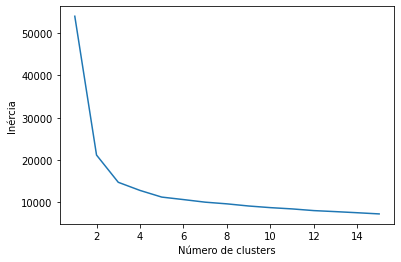

In [5]:
# Avaliza o número de clusters possíveis
inercia = []
for i in range(1, 16):
    cluster = KMeans(n_clusters=i, random_state=0)
    cluster.fit(matriz_cliente)
    inercia.append(cluster.inertia_)
    
plt.plot(range(1, 16), inercia)
plt.xlabel("Número de clusters")
plt.ylabel("Inércia") 
plt.show()

In [6]:
# Treina o modelo de clusterização para clientes e encontra os grupos
model_clientes = KMeans(n_clusters=5, random_state=0)
model_clientes.fit(matriz_cliente)

# Atualiza a matriz de dados para incluir grupo
colunas = [
    "nascimento", "escolaridade", "estado_civil",
    "renda", "criancas", "adolescentes", "grupo"
]
for n in range(0, qntd_registros):
    matriz_cliente[n].append(model_clientes.labels_[n])
    
matriz_cliente = pd.DataFrame(matriz_cliente, columns=colunas)

# Define o callback para volta da categoria
encodes = {
    "nascimento": lambda x: le_nascimento.inverse_transform([x])[0],
    "escolaridade": lambda x: le_escolaridade.inverse_transform([x])[0],
    "estado_civil": lambda x: le_estado_civil.inverse_transform([x])[0],
    "renda": lambda x: le_renda.inverse_transform([x])[0],
    "criancas": lambda x: x,
    "adolescentes": lambda x: x
}
    
# Encontra metadados sobre os clusters
metadados_clientes = []
for grupo in set(model_clientes.labels_):
    subset = matriz_cliente.loc[matriz_cliente["grupo"] == grupo]
    
    for campo in colunas[:-1]:
        categorias = set(subset[campo].values)
        
        for categoria in categorias:
            metadados_clientes.append({
                "grupo": grupo,
                "campo": campo,
                "categoria": str(encodes[campo](categoria)),
                "observacoes": list(subset[campo].values).count(categoria)
            })

metadados_clientes = pd.DataFrame(metadados_clientes)

## Descrevendo os grupos

- Grupo 0: Married/Together + Graduation + 0 criança + 0 adolescente + 1950-1980 + 76k-86k
- Grupo 1: Married/Together + Graduation + 0 criança + 1 adolescente + 1950-1980 + 46k-61k
- Grupo 2: Married/Together + Graduation + 1 criança + 0 adolescente + 1970-1990 + 16k-31k
- Grupo 3: Married/Together + Graduation + 0 criança + 1/0 adolescente + 1950-1980 + 61k-76k
- Grupo 4: Married/Together + Graduation + 1 criança + 1/0 adolescente + 1960-1990 + 31k-46k

In [7]:
# Para cada grupo, faz a descrição da composição
for grupo in set(model_clientes.labels_):
    print(f"AVALIANDO PARA O GRUPO {grupo}")
    
    subset = metadados_clientes.loc[metadados_clientes["grupo"] == grupo]
    for campo in set(subset["campo"].values):
        print(f"\nEstado para {campo}")
        
        temp = subset.loc[subset["campo"] == campo]
        total_observacoes = sum(temp["observacoes"].values)
        
        for i in range(0, len(temp)):
            categoria = temp["categoria"].values[i]
            observacoes = temp["observacoes"].values[i]
            
            print(f"{categoria}: {observacoes * 100 / total_observacoes}")
            
    print("===================================\n")

AVALIANDO PARA O GRUPO 0

Estado para adolescentes
0: 81.22977346278317
1: 17.475728155339805
2: 1.2944983818770226

Estado para renda
76000-81000: 44.336569579288025
81000-86000: 32.362459546925564
86000-91000: 13.915857605177994
91000-96000: 7.766990291262136
96000-101000: 1.6181229773462784

Estado para criancas
0: 94.1747572815534
1: 5.825242718446602

Estado para nascimento
1940-1950: 8.737864077669903
1950-1960: 23.300970873786408
1960-1970: 21.68284789644013
1970-1980: 24.919093851132686
1980-1990: 16.181229773462782
1990-2000: 5.17799352750809

Estado para escolaridade
2n Cycle: 8.414239482200648
Graduation: 51.13268608414239
Master: 16.828478964401295
PhD: 23.624595469255663

Estado para estado_civil
Absurd: 0.32362459546925565
Divorced: 10.032362459546926
Married: 38.83495145631068
Single: 22.977346278317153
Together: 23.948220064724918
Widow: 3.883495145631068

AVALIANDO PARA O GRUPO 1

Estado para adolescentes
0: 16.83778234086242
1: 78.2340862422998
2: 4.9281314168377826

